# Features that impact listing price

## Import Data and Library

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# reviews.csv will not be used in the analysis due to limited usability
calendar_csv = pd.read_csv('./project_1/calendar.csv')
listings_csv = pd.read_csv('./project_1/listings.csv')

## Project Motivation

In the first question we were trying to find out which features impact the daily rent price of the listing in 
Seattle. This is a big question for both the hosts and guests as both would like to maximize their price-value
ratio. Hosts want to set prices which bring in the most revenue, yet are still accessable enough to their 
target audience so that they won't be priced out of the market. Guests on the other hand want to pay the 
lowest price for their value range. In this part of the analysis we will look at both.

We have looked at various variables available in the dataset to try and predict which have the greatest 
impact on the price. Several methods of analysis have been incorporated in order to best present the problem 
at hand. Graphs, tables and a simple MLR model have been implemented. More details below...

## Data Cleaning and Preperation

Due to the unstructured format in which the raw .csv files are presented a lot of time and effort had to be 
invested in cleaning the data. We are dealing with what appears to be raw production data which requires a lot
of pre-processing in order to prepare it for further analysis. Several methods of data cleaning had to be 
undertaken to get a good grasp on our dataset.

First we have checked for missing values in both datasets and dropped variables with more than 50% of the rows
 missing.

In [3]:
def missing_cols(df):
    """
    The function quantifies the percentage of missing values in each column of the dataframe.
        * df: A pandas dataframe
    :returns: A pandas dataframe
    """
    return pd.DataFrame(df.isnull().mean() * 100, columns=['missing_values'])

miss_calendar = missing_cols(calendar_csv)
miss_listings = missing_cols(listings_csv)

After checking for missing values in both datasets we have decided on the 50% cutoff point. All columns with 
more than half of values missing will de dropped from the dataframe. Looking through the results no columns 
were dropped from **calendar_csv** but four columns had to be dropped from **listings_csv** due to the amount 
of missing values.

In [4]:
# No columns to drop from 'calendar_csv'
print(miss_calendar)

            missing_values
listing_id        0.000000
date              0.000000
available         0.000000
price            32.938998


In [6]:
# Four columns had to be dropped from 'listings_csv' due to amount of missing values
print(miss_listings[miss_listings.missing_values > 0].sort_values(by='missing_values', ascending=False))

                             missing_values
license                          100.000000
square_feet                       97.459403
monthly_price                     60.267156
security_deposit                  51.126244
weekly_price                      47.380828
notes                             42.063908
neighborhood_overview             27.029859
cleaning_fee                      26.977475
transit                           24.463070
host_about                        22.498690
host_acceptance_rate              20.246202
review_scores_accuracy            17.234154
review_scores_checkin             17.234154
review_scores_value               17.181771
review_scores_location            17.155579
review_scores_cleanliness         17.103195
review_scores_communication       17.050812
review_scores_rating              16.946045
last_review                       16.422211
first_review                      16.422211
reviews_per_month                 16.422211
space                           

After dropping the missing columns we have then merged the two datasets using a _'left join'_ on the 
**calendar_csv** to obtain a full time series of bookings and listing information. This way we were got full 
host information for each day along with the daily listing price for each unit.

In [9]:
# remove columns with more than half of the data missing and merge the two databases
def drop_and_join(df1, df2, df1_col: str, df2_col: str):
    """
    The functions checks the two dataframes for missing values and removes the columns where more than half 
    (> 0.5) of values are missing. It then left joins the two dataframes on selected columns.
        * df1: First dataframe to join on
        * df2: Second dataframe which will join on 'df1'
        * df1_col: Column in 'df1' to join by
        * df2_col: Column in 'df2' to join by
    :returns: A joined dataframe.
    """
    df1_miss = missing_cols(df1)
    df2_miss = missing_cols(df2)
    
    df1_clean = df1_miss[df1_miss.missing_values > 50]
    df2_clean = df2_miss[df2_miss.missing_values > 50]
    
    df1_subset = df1.loc[:, ~df1.columns.isin(df1_clean.index)]
    df2_subset = df2.loc[:, ~df2.columns.isin(df2_clean.index)]
    
    return pd.merge(left=df1_subset, right=df2_subset, how='left', left_on=df1_col, right_on=df2_col)

listings_full = drop_and_join(calendar_csv, listings_csv, df1_col='listing_id', df2_col='id')

The next order of business was to clean the data by replacing values with more meaningful descriptors, parsing 
numerical variables and reducing the size of the data frame in order to speed up the calculations.

In [12]:
def clean_data(df):
    """
    Function takes a joined 'df' and cleans it by removing redundant columns, renaming values and generating 
    new columns.
        * df: merged dataframe of 'calendar.csv' and 'listings.csv'
    :returns: A cleaned dataframe.
    """
    # remove URL columns which are redundant
    url_cols = df.filter(like='url')
    df_no_url = df.loc[:, ~df.columns.isin(url_cols.columns)].copy()
    
    # rename 'price' columns
    df_no_url.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)
    
    # replace values with meaningful descriptors
    cols_to_replace = {
        'host_is_superhost': {'t': 'superhost', 'f': 'regular'},
        'available': {'t': 'free', 'f': 'booked'}
    }
    
    for k, v in cols_to_replace.items():
        df_no_url[k].replace(
            to_replace=v,
            inplace=True
        )
    
    # add 'year' and 'month' variables
    df_no_url['year'] = pd.DatetimeIndex(df_no_url['date']).year
    df_no_url['month'] = pd.DatetimeIndex(df_no_url['date']).month
    
    # drop cols with single unique value
    cols_len_one = []
    
    for i in df_no_url.columns:
        if len(df_no_url[i].unique()) == 1:
            cols_len_one.append(i)
    
    df_clean = df_no_url.loc[:, ~df_no_url.columns.isin(cols_len_one)].copy()
    
    # reformat price columns into a float dtype
    for col in ['price', 'weekly_price', 'cleaning_fee', 'extra_people']:
        df_clean[col] = df_clean[col].str.replace(',', '').str.replace('$', '').astype(float)
    
    # reformat 'host_response_rate'
    df_clean.host_response_rate = df_clean.host_response_rate.str.replace('%', '').astype(float) / 100
    
    # further remove redundant columns
    cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit',
                    'host_name', 'host_location', 'host_about', 'street', 'neighborhood_overview', 'zipcode',
                    'smart_location', 'latitude', 'longitude', 'price_y', 'calendar_updated', 'neighbourhood',
                    'host_acceptance_rate', 'state', 'city', 'is_location_exact']
    
    return df_clean.loc[:, ~df_clean.columns.isin(cols_to_drop)]

seattle_df_clean = clean_data(listings_full)

<ipython-input-12-10cb872205ed>:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_clean[col] = df_clean[col].str.replace(',', '').str.replace('$', '').astype(float)


Next, we have to drop missing rows from the  _**price**_ column.

In [13]:
# Remove NA from predictive variable
price = seattle_df_clean.iloc[:, [3, 1, 4]].dropna(axis=0)

value_listings_db = pd.merge(left=seattle_df_clean, right=price, how='inner', on=['date', 'id'])
value_listings_db.drop(axis=1, labels='price_y', inplace=True)
value_listings_db.rename(columns={'price_x': 'price'}, errors='raise', inplace=True)

## Data Analysis

### Correlation plot

Finally, after successfully cleaning our dataset we were able to start looking at the data with a more 
analytical mindset. We started off with a correlation plot of numerical variables to see if any strong 
correlations exist with our response variable.

AxesSubplot(0.125,0.125;0.62x0.755)


[]

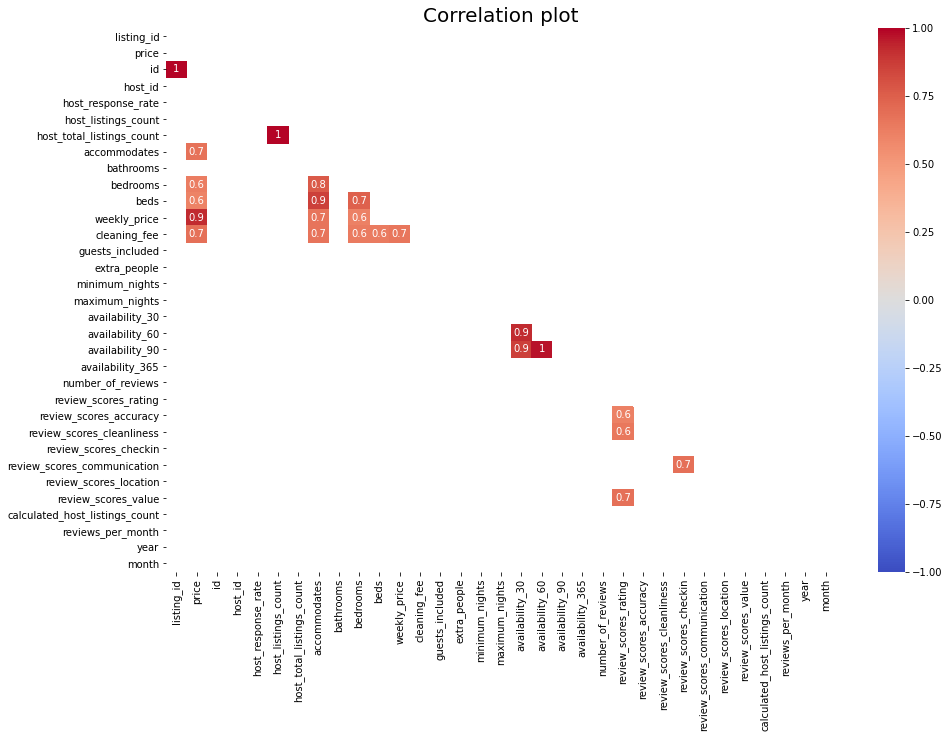

In [14]:
def correlation_matrix(df):
    """
    Creates a correlation plot from numeric variables and plots values which are correlated > 0.6 with price.
        * df: Input dataframe
    :return: Correlation matrix of 'df' variables
    """
    num_cols = []

    for i in df:
        if df[i].dtype in ('float64', 'int64'):
            num_cols.append(i)

    df = df.iloc[:, df.columns.isin(num_cols)]

    # check for correlation between variables
    value_cor = df.corr()
    matrix = np.triu(df.corr())

    print(
        sns.heatmap(value_cor[value_cor > .6], annot=True, fmt='.1g', vmin=-1, vmax=1, center=0,
                    cmap='coolwarm', mask=matrix)
    )


f, ax = plt.subplots(1, 1, figsize = (15, 10))
correlation_matrix(value_listings_db)
plt.title('Correlation plot', size=20)
plt.plot()

We can observe several variables which are highly correlated with price:

- accomodates
- bedrooms
- beds
- weekly_price
- cleaning_fee

Additionally, we can see that these variables are highly correlated with each other which is something we 
should keep in mind as we continue our analysis.

### Plotting and Aggregating Data

Next we introduce some graphs and data aggregation to get a feel for our dataset.

Looking at the _'property type'_ variable we can see that the mean price of properties in the observed period 
reaches up to ~160$ per day with the exception of boats which are almost double the price. Looking at the 
table at the bottom we can see that there are not that many boats available and so this category can be 
treated as an outlier.

[]

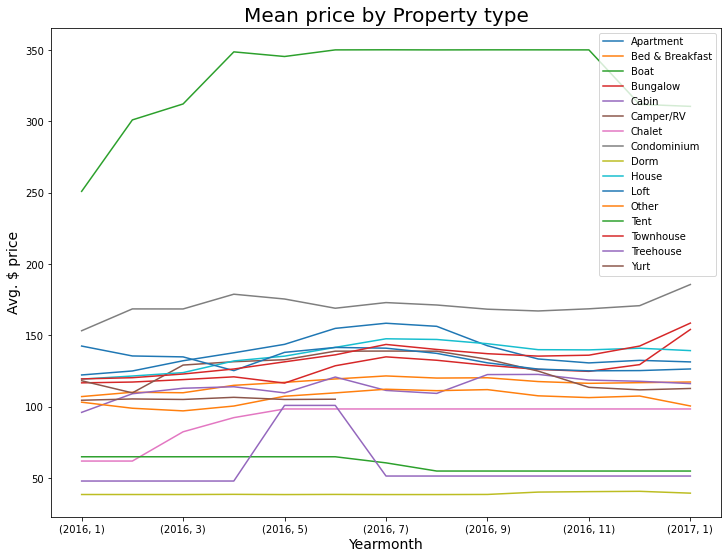

In [15]:
# property type
f, ax = plt.subplots(1, 1, figsize = (12, 9))
value_listings_db.pivot_table(index=['year', 'month'], values='price', columns='property_type', aggfunc=np.mean).plot(
    ax=ax).legend(loc='upper right')
plt.title('Mean price by Property type', size=20)
plt.xlabel("Yearmonth", size=14)
plt.ylabel("Avg. $ price", size=14)
plt.plot()

In fact we can only use **houses** and **apartments** and potentially **townhouses** and **condos** for our 
analysis since the rest of the properties present less than 5% of total listings in the sample.

In [16]:
property_type_agg = value_listings_db.pivot_table(
    index='property_type', values='listing_id', aggfunc=pd.Series.nunique).sort_values(
    by='listing_id', ascending=False)
property_type_agg['listing_pct']=(property_type_agg.listing_id/sum(property_type_agg.listing_id))*100

print(property_type_agg)

                 listing_id  listing_pct
property_type                           
House                  1686    45.298227
Apartment              1667    44.787749
Townhouse               117     3.143471
Condominium              88     2.364320
Loft                     40     1.074691
Bed & Breakfast          36     0.967222
Other                    22     0.591080
Cabin                    20     0.537346
Bungalow                 13     0.349275
Camper/RV                13     0.349275
Boat                      8     0.214938
Tent                      4     0.107469
Treehouse                 3     0.080602
Chalet                    2     0.053735
Dorm                      2     0.053735
Yurt                      1     0.026867


Looking at the _room_type_ variable we can see a clear distinction in the price between various types of 
listings. The `Entire home/apt` definitely has an edge in terms of average rental price.

[]

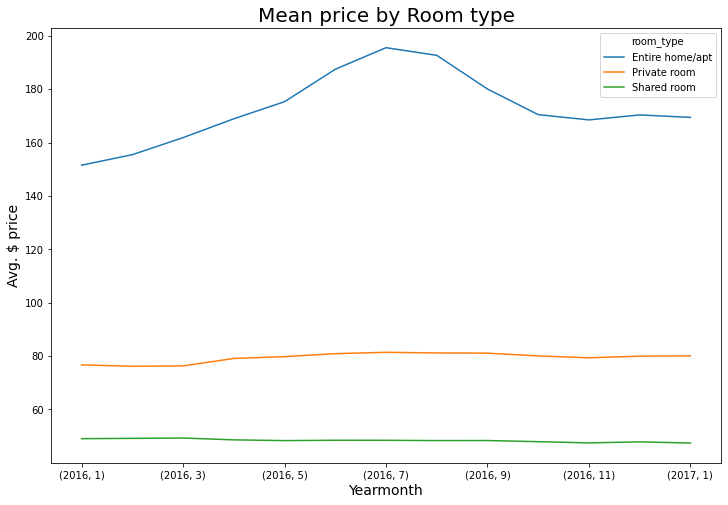

In [17]:
f, ax = plt.subplots(1, 1, figsize = (12, 8))
value_listings_db.pivot_table(
    index=['year', 'month'], values='price', columns='room_type', aggfunc=np.mean).plot(
    ax=ax)
plt.title('Mean price by Room type', size=20)
plt.xlabel("Yearmonth", size=14)
plt.ylabel("Avg. $ price", size=14)
plt.plot()

Moving on to _accommodates_ we can observe that the majority of listings houses up to 6 people which 
coincides with the fact that the majority of property types are houses and apartments. Additionally, the 
price of the listing increases fairly linearly with the number of people it accommodates so no surprises there.

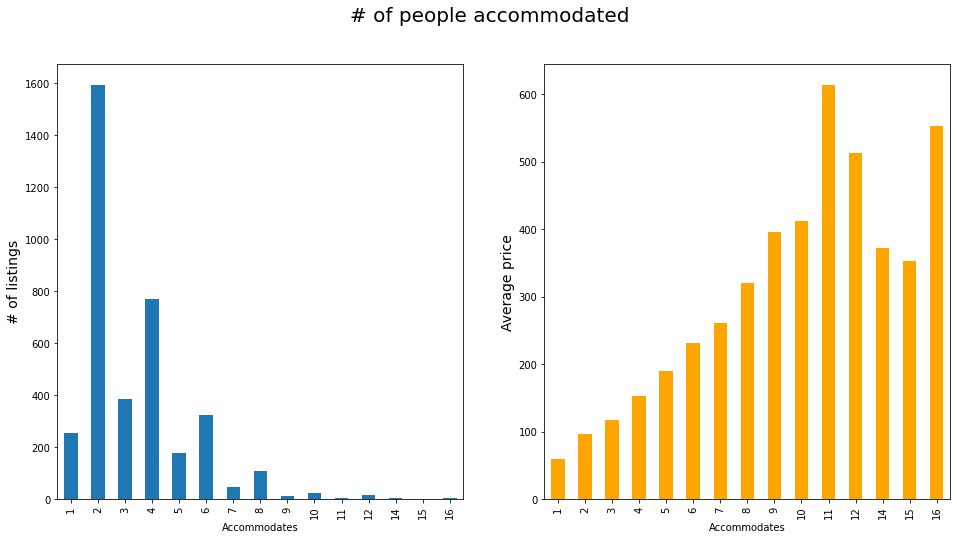

In [18]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
value_listings_db.pivot_table(values='listing_id', index='accommodates', aggfunc=pd.Series.nunique).plot(
    kind='bar', ax=axs[0], legend=False)
value_listings_db.pivot_table(values='price', index='accommodates', aggfunc=np.mean).plot(
    kind='bar', color='orange', ax=axs[1], legend=False)
plt.suptitle('# of people accommodated', size=20)
plt.setp(axs[[0,1]], xlabel='Accommodates')
axs[0].set_ylabel('# of listings', size=14)
axs[1].set_ylabel('Average price', size=14)
plt.show()

Another interesting variable to look at is the _'cancellation policy'_ which indicates the kind of policy 
the host keeps in case of cancellations.

We can observe that the majority of hosts relies on **strict** cancellation policy which interestingly enough
coincides with higher average price of those listings.

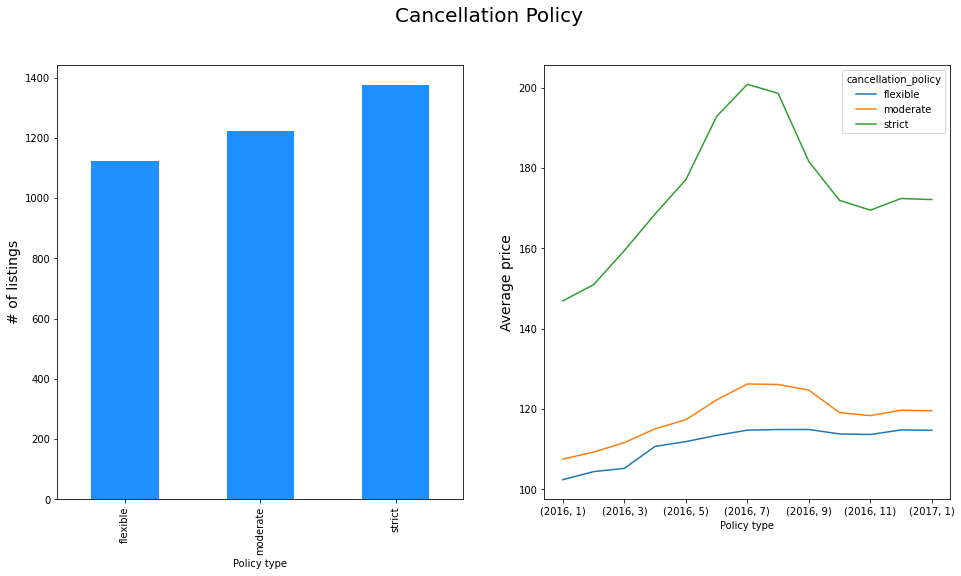

In [19]:
my_cols = ['dodgerblue', 'orange', 'mediumseagreen']

f, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
value_listings_db.pivot_table(values='listing_id', columns=['cancellation_policy'],aggfunc=pd.Series.nunique).T.plot(
    kind='bar', color=my_cols, ax=axs[0], legend=False)
value_listings_db.pivot_table(values='price', index=['year', 'month'], columns=['cancellation_policy'], aggfunc=np.mean).plot(
    ax=axs[1])
plt.suptitle('Cancellation Policy', size=20)
plt.setp(axs[[0,1]], xlabel='Policy type')
axs[0].set_ylabel('# of listings', size=14)
axs[1].set_ylabel('Average price', size=14)
plt.show()

### Regression model

Now that we have singled out a few relevant variables we can apply a simple regression model to confirm our 
observations about which variables affect listing price. We start out by creating several dummy variables from 
existing categorical columns since we can only apply the model to numerical variables.

In [20]:
# apply a multiple regression model
dummy_cols = ['available',
              'host_response_time',
              'host_is_superhost',
              'host_has_profile_pic',
              'host_identity_verified',
              'property_type',
              'room_type',
              'bed_type',
              'instant_bookable',
              'cancellation_policy',
              'require_guest_profile_picture',
              'require_guest_phone_verification']

value_listings_lr = pd.get_dummies(value_listings_db, columns=dummy_cols)

Next, we choose a set of variables which could potentially predict the daily listing price. We should be 
careful to avoid any variables which are highly correlated with the dependent variable - price - due to 
multicollinearity (more on this [here](https://en.wikipedia.org/wiki/Multicollinearity)).

The initial set consisted of the following predictor variables:

- accommodates
- cancellation_policy_strict
- property_type_Apartment
- property_type_Condominium
- property_type_House
- property_type_Townhouse

The last two variables had little effect in explaining the price of the listing so we have decided to drop 
them in order to reduce the number of variables and avoid over-fitting the model. Following this were left 
with four variables in our model and barely a reduction in our Adj. R-sq value. Below is a detailed summary 
of the results.

In [21]:
def listing_price_regresssion(df, regression_cols: list):
    """
    Function returns the results of a MLR on the input dataframe with the selected columns in 'column_set' 
    acting as independent variables in the regression model.
        * df - Dataframe containig the data for the analysis
        * regression_cols - A list containing the indices of columns used as indipendent variables
    :return: A linear regression model
    """
    cols = regression_cols
    lr_test_set = df.iloc[:, lambda df: cols]
    lr_test_clean = lr_test_set.dropna(axis=0)
    y = lr_test_clean.price
    x = lr_test_clean.drop(axis=1, columns=['price'])
    x = sm.add_constant(x, prepend=False)
    
    model = sm.OLS(y, x.drop(axis=1, columns=[]))
    results = model.fit()
    
    return results

mlr = listing_price_regresssion(value_listings_lr, regression_cols=[2, 13, 15])

print(mlr.summary())
    

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 4.444e+05
Date:                Tue, 07 Sep 2021   Prob (F-statistic):               0.00
Time:                        10:59:54   Log-Likelihood:            -5.3524e+06
No. Observations:              932539   AIC:                         1.070e+07
Df Residuals:                  932536   BIC:                         1.070e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
accommodates    24.4945      0.061    402.401   

### Interpretation of the results

We have taken a look at the Seattle Airbnb dataset and tried to find out whether there exist any variables 
within the dataset which could help us to predict the price of a listing. Several methods of analysis have 
been used to try to extract this information. First, we have used correlation plots, pivot tables and graphs 
to try and eyeball any potential candidates. Then we have applied a simple multiple linear regression model to 
confirm our findings.

The results of the MLR model tell us that the two selected variables - _accomodates_, _bedrooms_ - account for
almost 50% of the variability within the _price_ variable. This should not come as a surprise since the number
of guests and number of bedrooms determine the size of the listing and by extension also its price. 

There are also other variables in the dataset which have been tested in the model, but none have such a strong
explanatory power as the two above. With further exploration and feature generation a better model could be
constructed, but for this exercise this should suffice.